<a href="https://colab.research.google.com/github/delonfadhil/MachineLearningTasks/blob/main/6thWeekTasks/Clustering%20SKLearn/4_Spectral_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Fadhil Dzikri Aqila

NIM : 1103213136

Scikit-learn.org [Spectral clustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering)

#2.3.5. Spectral clustering

###[Spectral clustering for image segmentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html#sphx-glr-auto-examples-cluster-plot-segmentation-toy-py): Segmenting objects from a noisy background using spectral clustering

####Generate the data

In [1]:
import numpy as np

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1**2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2**2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3**2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4**2

####Plotting four circles

In [2]:
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

In [3]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(img, mask=mask)

In [4]:
graph.data = np.exp(-graph.data / graph.data.std())

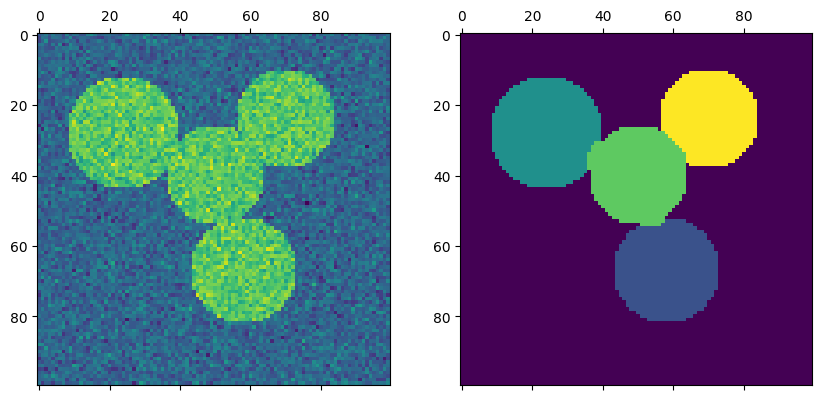

In [5]:
import matplotlib.pyplot as plt

from sklearn.cluster import spectral_clustering

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

####Plotting two circles

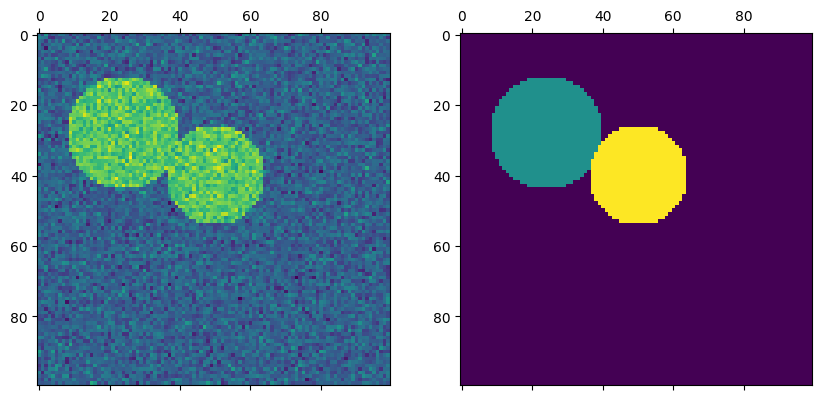

In [6]:
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()